# Laplacian Eigenmaps and Spectral Embedding

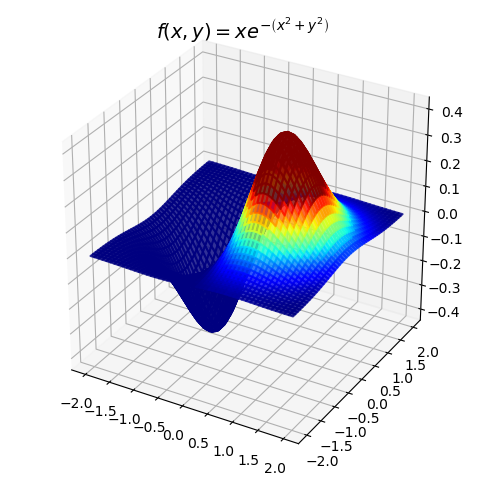

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
np.random.seed(8888)
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# draw samples to create the grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
x,y = np.meshgrid(x,y)

# scalar function
z = x*np.exp(-1*(x**2 + y**2))

# plot 3d surface
fig = plt.figure(figsize = (6, 6))
ax = fig.gca(projection = '3d')
colors = plt.cm.jet(z*4)
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=colors, cmap=plt.cm.coolwarm, linewidth=1.4, alpha=0.8)
ax.set_title(r'$f(x, y)=x e^{-\left(x^{2}+y^{2}\right)}$', size=14);

## Graph Laplacian with networkx

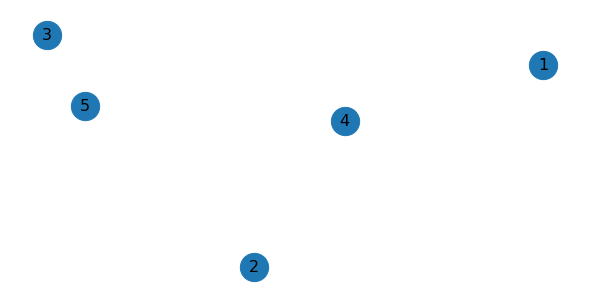

In [2]:
import networkx as nx

# adding a list of edges:
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5])
pos = nx.random_layout(G, seed=8888)
plt.figure(figsize=(8,4))
nx.draw(G,pos,node_size=800,font_size=16,with_labels=True)
plt.show();

In [3]:
pos

{1: array([0.96238434, 0.69422036], dtype=float32),
 2: array([0.44226614, 0.02448785], dtype=float32),
 3: array([0.07069068, 0.7940371 ], dtype=float32),
 4: array([0.6052884, 0.5077291], dtype=float32),
 5: array([0.13890399, 0.5566335 ], dtype=float32)}

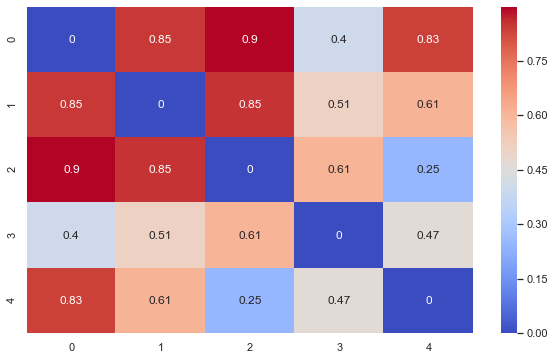

In [4]:
from sklearn.metrics import pairwise_distances
import seaborn as sns
X = np.array(list(pos.values()))
A = pairwise_distances(X)
plt.figure(figsize=(10,6))
sns.set()
sns.heatmap(A, cmap="coolwarm", annot=True);

In [5]:
# number of nearest neighbors for the graph.
k = 2

# get indices and sorted distances
DNN, NN = np.sort(A), np.argsort(A)
NN = NN[:,1:k+1]
DNN = DNN[:,1:k+1]
edges = []
for i in range(len(NN)):
    for j in range(len(NN[i])):
        edges.append((i+1, NN[i][j] + 1))
# list of edge pairs        
edges

[(1, 4),
 (1, 5),
 (2, 4),
 (2, 5),
 (3, 5),
 (3, 4),
 (4, 1),
 (4, 5),
 (5, 3),
 (5, 4)]

C:\Users\GAO\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


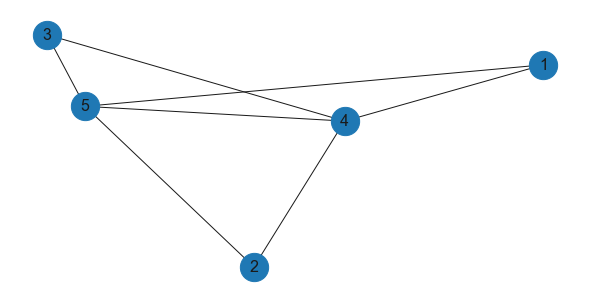

In [7]:
# adding a list of edges:
G.add_edges_from(edges)
plt.figure(figsize=(8,4))
nx.draw(G,pos,node_size=800,font_size=16,with_labels=True)
plt.show();

In [8]:
# optional heat kernel for edge weights
def heat_kernel(x, y):
    dist_2 = np.linalg.norm(x - y)**2
    w = np.exp(-dist_2)
    return w

def laplacian(X, gaussian=False):
    if gaussian:
        W = np.zeros((X.shape[0], X.shape[0]))
        for i in range(W.shape[0]):
            for j in range(W.shape[0]):
                if j in NN[i]:
                    W[i][j] = heat_kernel(X[i], X[j])
        node_degrees = W.sum(axis=1)
    else:
        W = nx.adjacency_matrix(G).todense()
        node_degrees = [x[1] for x in list(G.degree())]
    # create diagonal degree matrix
    D = np.diag(node_degrees)
    print('Adjacency matrix: \n', W)
    print('Degree matrix: \n', D)
    L = D - W
    print('Laplacian matrix: \n', L)
    return L

L = laplacian(X)

Adjacency matrix: 
 [[0 0 0 1 1]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [1 1 1 0 1]
 [1 1 1 1 0]]
Degree matrix: 
 [[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]
Laplacian matrix: 
 [[ 2  0  0 -1 -1]
 [ 0  2  0 -1 -1]
 [ 0  0  2 -1 -1]
 [-1 -1 -1  4 -1]
 [-1 -1 -1 -1  4]]


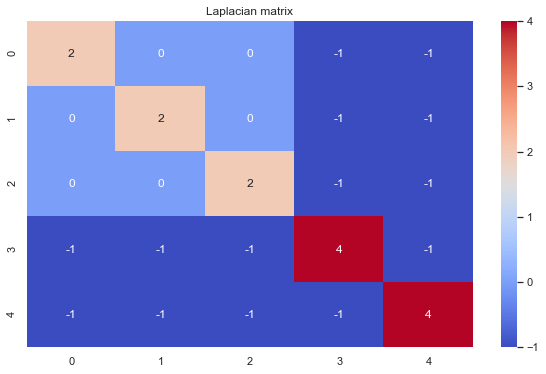

In [9]:
plt.figure(figsize=(10,6))
plt.title('Laplacian matrix')
sns.heatmap(L, annot=True, cmap="coolwarm");

Largest eigenvalue: 4.999999999999999
Smallest eigenvalue: -1.1102230246251565e-16


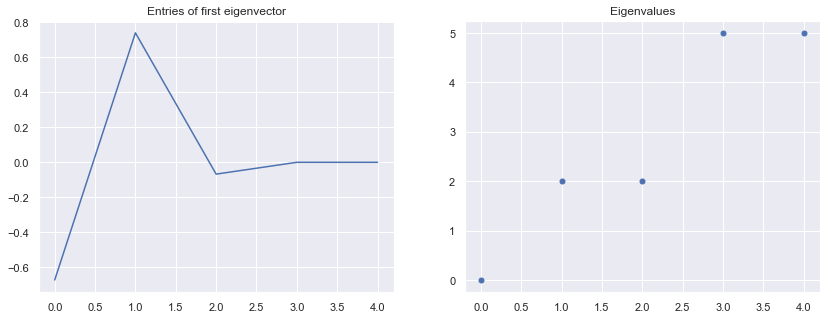

In [10]:
import pandas as pd
from networkx import *
eigvals, eigvecs=np.linalg.eigh(L)
print("Largest eigenvalue:", max(eigvals))
print("Smallest eigenvalue:", min(eigvals))

eigvecs = pd.DataFrame(eigvecs)

fig = plt.figure(figsize=(14,5))
fig.add_subplot(121)
plt.title("Entries of first eigenvector")
m = 1
for i in range(1, m+1):
    plt.plot(eigvecs.iloc[:10,i])
    
fig.add_subplot(122)
plt.plot(eigvals, '.', markerSize = 10)
plt.title("Eigenvalues");

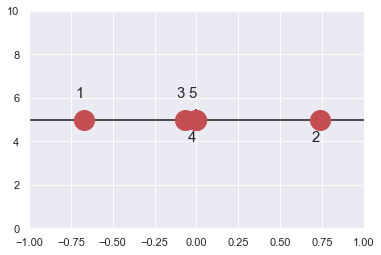

In [11]:
# set up figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-1,1)
ax.set_ylim(0,10)

# draw lines
xmin = -1
xmax = 1
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(0, y - height / 2., y + height / 2.)

# use eigenvectors to map points to the line
for index, px in enumerate(eigvecs.iloc[:,1]):
    plt.plot(px, y, 'ro', ms = 20, mfc = 'r')
    plt.text(px, y + (-1)**index, str(index+1), horizontalalignment='right', size=15)

plt.show();

## Brown Corpus Text Data

In [13]:
import nltk
path = 'C:/Users/GAO/Jupyter/data/nltk_data/corpora'
from nltk.corpus import brown

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

brown.categories()

C:\Users\GAO\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [14]:
sent_dict = {}
brown_categories = ['news', 'fiction', 'reviews']
for category in brown_categories:
    sent_dict[category] = np.array(brown.sents(categories=category))

In [15]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
stop_words = set(stopwords.words('english')) 

# define functions for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
train_text = [' '.join(sent) for sent in brown.sents(categories=brown_categories)]
text = remove_stopwords(train_text)

from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000,
                             ngram_range=(1, 3))
vectorizer.fit(train_text)
feature_vec = vectorizer.fit_transform(train_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=6000, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(feature_vec)

In [18]:
feature_data = []
for category in sent_dict:
    cat_data = [' '.join(sent) for sent in sent_dict[category]]
    feature_data.append(tf_transformer.transform(
        vectorizer.transform(cat_data)))

df = [np.array(arr.todense()) for arr in feature_data]

category_labels = []
for category in brown_categories:
    category_labels.append(np.repeat(category, len(
        np.array(brown.sents(categories=category)))))

labels = np.hstack((category_labels))
final_df = np.vstack((df))

final_df.shape
labels.shape

(10623, 6000)

(10623,)

In [19]:
data = pd.DataFrame(final_df)
data['label'] = labels
data = data.loc[np.random.randint(0, len(data), size=1500)]
data.head()
data.shape
final_data = data.drop(['label'], axis=1)
final_labels = np.array(data['label'])

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,label
4483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,news
2120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,news
6825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,fiction
5612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.201527,0.0,0.0,0.0,0.0,0.0,0.0,fiction
2224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,news


(1500, 6001)

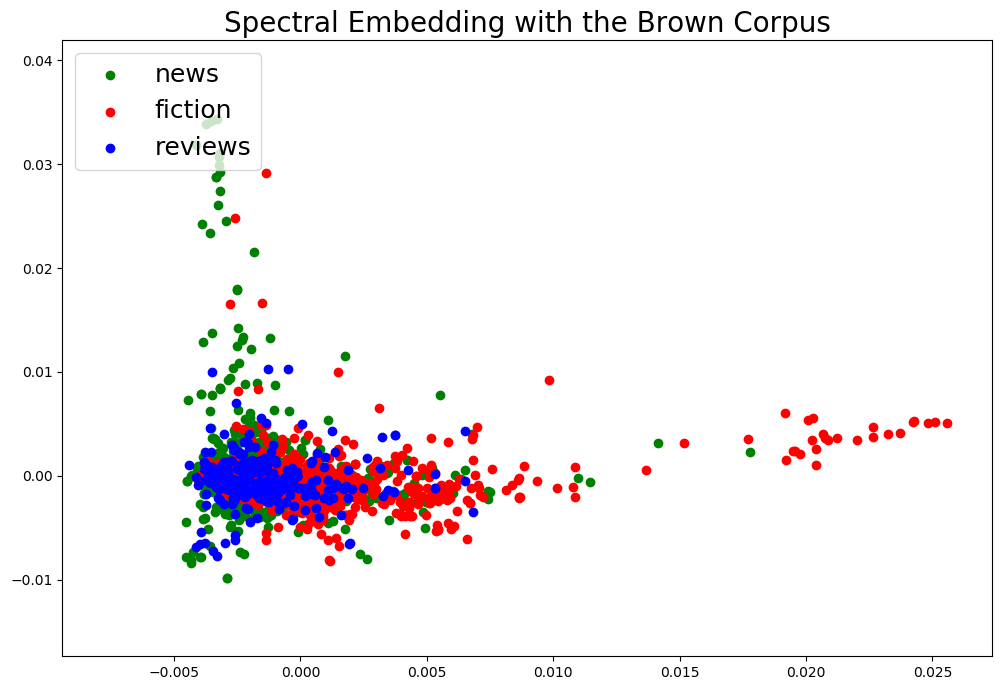

In [23]:
from sklearn.manifold import SpectralEmbedding
# apply spectral embedding with output dimension = 2
model = SpectralEmbedding(n_components=2, n_neighbors=45)
proj = model.fit_transform(final_data)

# plot the spectral embedding
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(12,8))
colors = {'news': 'green', 'religion': 'purple', 'fiction': 'red', 'government': 'black',
         'reviews': 'blue'}

plt.scatter(proj[data['label'] == 'news', 0], proj[data['label'] == 'news', 1], c='green', label='news')
plt.scatter(proj[data['label'] == 'fiction', 0], proj[data['label'] == 'fiction', 1], c='red', label='fiction')
plt.scatter(proj[data['label'] == 'reviews', 0], proj[data['label'] == 'reviews', 1], c='blue', label='reviews')
plt.title('Spectral Embedding with the Brown Corpus', size=20)
plt.legend(loc='upper left', fontsize=18)
plt.show();

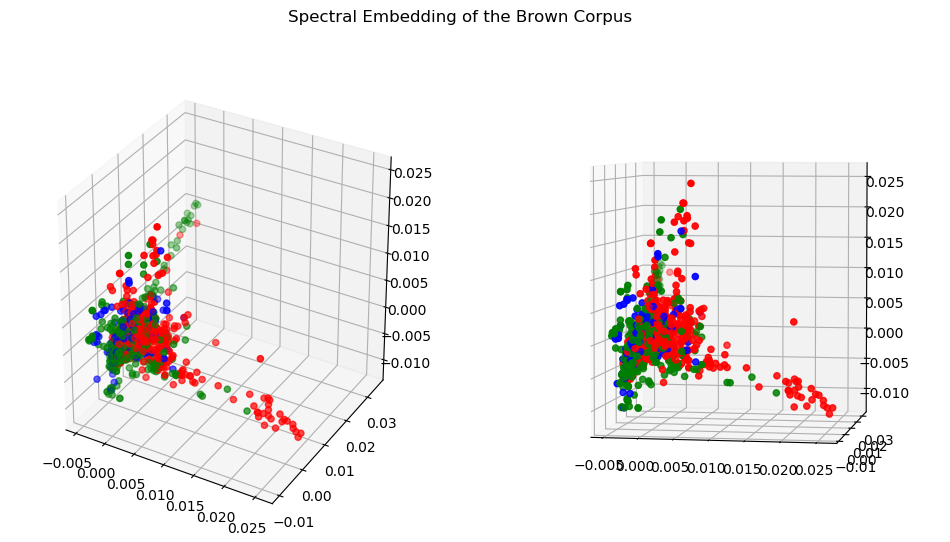

In [22]:
from sklearn.manifold import SpectralEmbedding
%matplotlib inline
# apply spectral embedding with output dimension = 3
model = SpectralEmbedding(n_components=3, n_neighbors=45)
proj = model.fit_transform(final_data)

# plot the spectral emedding
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
colors = {'news': 'green', 'religion': 'purple', 'fiction': 'red', 'government': 'black',
          'reviews': 'blue'}
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2],
           c=data['label'].apply(lambda x: colors[x]))

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2],
           c=data['label'].apply(lambda x: colors[x]))
ax.view_init(4, -80)
plt.suptitle('Spectral Embedding of the Brown Corpus')
plt.show();